TODO:
 - speed up data likelihood (and precompute $\log | \Sigma |$)
 - the swapped indices thing

In [1]:
using Distributions
using Seaborn

In [2]:
include("src/CHMM.jl")
# include("src/auxiliary.jl")
# include("src/chmm.jl")
# include("src/chmm_training.jl")

update_parameter_estimates! (generic function with 2 methods)

In [3]:
K = 5
KK = K^2
D = 3
model = rand_chmm(K, D)
(X, Z, traj_ptr, traj_pairs) = rand_trajs(model, 
    T_range=100:300, N_pairs=100)
;

In [4]:
num_trajs = length(traj_ptr) - 1
num_pairs = length(traj_pairs)
traj_lens = diff(traj_ptr)

# drop a couple of trajectories
traj_pairs_full = copy(traj_pairs)


# traj_pairs = traj_pairs[ randperm(num_pairs)[1:Int(num_pairs/2)] ]
traj_pairs = traj_pairs[[1]] #################################################


num_pairs = length(traj_pairs)

num_singles = num_trajs - num_pairs * 2
traj_singles = setdiff(1:num_trajs, vcat([[p...] for p in traj_pairs]...))
;

## EM

In [30]:
curr = chmm_from_data(X, K)
suff = ChmmSuffStats(curr)

log_p0 = log.(outer(curr.π0))

log_P = empty(KK, KK)
for k in 1:KK
    i, j = ind2sub((K, K), k)
    outer!(reshape(view(log_P, :, k), K, K), curr.P[:, i, j])
end
map!(log, log_P, log_P)

T_max = maximum(diff(traj_ptr))

log_b = empty(KK, T_max)
log_α = similar(log_b)
log_β = similar(log_b)
γ = similar(log_b)
;

In [31]:
for i in 1:K
    curr.μs[i][:] = randn(D) * 10
end

In [32]:
curr.μs

5-element Array{Array{Float64,1},1}:
 [-3.29239, 11.0064, -8.45707]
 [-1.16615, 3.02157, -24.165] 
 [-4.70355, 2.49545, 17.8605] 
 [-2.22696, 4.52798, 16.5479] 
 [15.6264, -1.93363, 8.70836] 

In [126]:
include("src/chmm_training.jl")

update_parameter_estimates! (generic function with 2 methods)

In [33]:
N_iters = 50
log_like_hist = fill(NaN, N_iters)
verbose = true
print_every = 10

for iter in 1:1
    log_like = 0.0
    zero!(suff)
    
    #
    # Pairwise Trajectories
    #
    for (id1, id2) in [] #traj_pairs
        X1 = get_trajectory(id1, X, traj_ptr)
        X2 = get_trajectory(id2, X, traj_ptr)
        
        T = size(X1, 2)
        @assert T == size(X2, 2)
    
        data_likelihood!(PairwiseTrajectory, 
            curr, X1, X2, log_p0, log_P, log_b)
        log_like += forward_backward!(curr, T,
            log_p0, log_P, log_b, log_α, log_β, γ)
        update_suff_stats!(PairwiseTrajectory, 
            suff, X1, X2, log_p0, log_P, γ)
    end

    #
    # Single Trajectories
    #
    for id in [1] #traj_singles
        Xt = get_trajectory(id, X, traj_ptr)
        T = size(Xt, 2)
        
        data_likelihood!(SingleTrajectory, 
            curr, Xt, log_p0, log_P, log_b)
        log_like += forward_backward!(curr, T,
            log_p0, log_P, log_b, log_α, log_β, γ)
        update_suff_stats!(SingleTrajectory, 
            suff, Xt, log_p0, log_P, γ)
    end

    #
    # combine info from all trajectories
    #    
    update_parameter_estimates!(curr, suff)
    
    log_like_hist[iter] = log_like
    verbose && (iter % print_every == 0) && @printf("iteration %6d:  %.3f\n", iter, log_like)
    
    if (iter ≥ 2) && (abs(log_like_hist[iter] - log_like_hist[iter - 1]) ≤ conv_tol)
        break
    end
end

In [65]:
T = first(traj_lens)

284

In [37]:
sum(traj_lens[1:3])

761

In [38]:
sum(traj_lens[[1, 3]])

477

In [96]:
k = 1

1

In [115]:
model.Σs[k]

3×3 Array{Float64,2}:
 0.571391  0.0       0.0     
 0.0       0.571391  0.0     
 0.0       0.0       0.571391

In [116]:
curr.Σs[k]

3×3 Array{Float64,2}:
  64.6341  -22.2252   19.832 
 -22.2252  -45.0764   24.9121
  19.832    24.9121  -12.5363

In [117]:
isposdef(curr.Σs[k])

false

In [133]:
tm = zeros(D)
for t in 1:T
    p = reshape(γ[:, t], (K, K))
    o = X[:, t]
    pz = sum(p[k, :])
    tm .+= pz * o
end
tm ./= suff.counts_K[k]

3-element Array{Float64,1}:
  2.82763
 14.5404 
 -8.40241

In [139]:
tS1 = zeros(D, D)
for t in 1:T
    p = reshape(γ[:, t], (K, K))
    o = X[:, t] .- tm
    pz = sum(p[k, :])
    tS1 .+= pz * o * o'
end
tS1 ./= suff.counts_K[k]
tS1 = (tS1 + tS1')/2

3×3 Array{Float64,2}:
  66.9838  -10.1422   12.8496 
 -10.1422   17.0579  -10.9933 
  12.8496  -10.9933    8.21219

In [140]:
isposdef(tS1)

true

In [141]:
tS2 = zeros(D, D)
for t in 1:T
    p = reshape(γ[:, t], (K, K))
    o = X[:, t]
    pz = sum(p[k, :])
    tS2 .+= pz * o * o'
end
tS2 ./= suff.counts_K[k]
tS2 .-= tm * tm'
tS2 = (tS2 + tS2')/2

3×3 Array{Float64,2}:
  64.6341  -22.2252   19.832 
 -22.2252  -45.0764   24.9121
  19.832    24.9121  -12.5363

In [142]:
 isposdef(tS2)

false

In [40]:
suff.counts_KK |> sum

283.99999999998005

In [41]:
suff.ms

5-element Array{Array{Float64,1},1}:
 [225.094, 1157.49, -668.875]            
 [1.26225e-65, 9.78874e-66, -6.18205e-66]
 [-9.70838e-7, 7.45209e-6, 1.45325e-5]   
 [-32.4028, 385.055, 689.386]            
 [1110.25, 5.21374, 904.722]             

In [25]:
model.μs

5-element Array{Array{Float64,1},1}:
 [10.3957, 3.26583, 6.03191]  
 [10.336, 9.63485, -4.77635]  
 [-4.11489, 12.4727, -7.88772]
 [-0.537493, 8.55844, 15.3948]
 [6.53086, -2.44013, 6.91043] 

In [24]:
curr.μs

5-element Array{Array{Float64,1},1}:
 [6.00093, 2.24089, 8.78303]             
 [-4.14655, 12.4746, -7.88803]           
 [1.36135e-42, 1.00084e-42, -6.31514e-43]
 [5.96934, -4.72486, 5.13303]            
 [10.279, 9.73686, -4.70588]             

In [52]:
map(isposdef, curr.Σs)

5-element Array{Bool,1}:
 false
  true
  true
  true
 false

In [57]:
X1 = get_trajectory(1, X, traj_ptr)
X2 = get_trajectory(2, X, traj_ptr)
;

In [ ]:
T = size(X1, 2)
@assert T == size(X2, 2)

data_likelihood!(PairwiseTrajectory, 
    curr, X1, X2, log_p0, log_P, log_b)

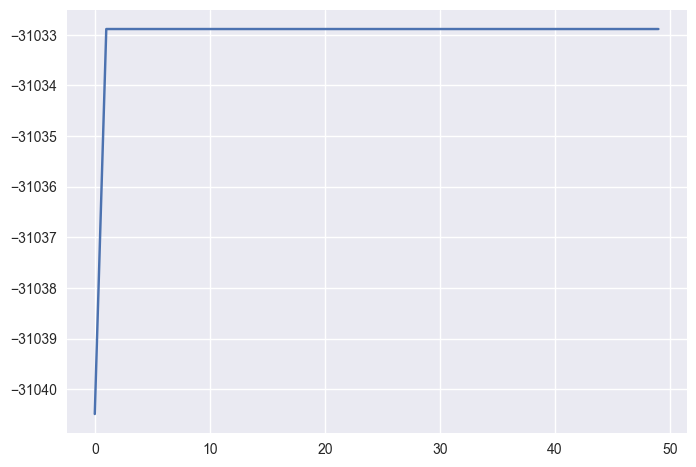

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003D6EE898>

In [72]:
plot(log_like_hist)

# Analysis

In [ ]:
true_to_est_lut = empty(Int, K)
for i in 1:K
    m = model.μs[i]
    r = map(mm -> norm(m .- mm), curr.μs)
    true_to_est_lut[i] = indmin(r)
end

In [112]:
P_true = copy(model.P)
P_hat = copy( curr.P[true_to_est_lut, true_to_est_lut, true_to_est_lut] )
maximum(P_true .- P_hat)

0.2896134348057094

In [113]:
p0_true = copy(model.π0)
p0_hat = copy( curr.π0[true_to_est_lut] )
maximum(p0_true .- p0_hat)

0.1810702700057717

In [120]:
hcat([model.μs[i] .- curr.μs[true_to_est_lut[i]] for i in 1:K] ...)

2×3 Array{Float64,2}:
 0.00625976   0.00261317  -0.0105945
 0.00156944  -0.00314787   0.0187559

In [60]:
t = reshape(suff.P_flat[:, 5], K, K)
t ./ sum(t)

5×5 Array{Float64,2}:
 0.0882851  0.0677451  0.021348    0.0107783   0.0392844
 0.119294   0.107528   0.0509302   0.0235713   0.108796 
 0.0462925  0.0571043  0.019985    0.00841619  0.0291007
 0.0254451  0.0185579  0.00599994  0.00237123  0.0120826
 0.0378233  0.0420096  0.0156117   0.00606519  0.0355745

In [119]:
vcat([norm(model.Σs[i] .- curr.Σs[true_to_est_lut[i]]) for i in 1:K] ...)

3-element Array{Float64,1}:
 0.0453783
 0.0126107
 0.0255573